In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_results = pd.read_csv("data/dqn_results_20251201.csv")
df_results.head()

,AoI,Dropped_Ratio
0,1.3455,0.2048
1,1.2479,0.2229
2,1.2798,0.2892
3,1.2137,0.3253
4,1.2210,0.3855


In [8]:
from src.utils.report import calc_running_mean_adaptive

window_size = 4
aoi_mean = calc_running_mean_adaptive(df_results["AoI"], window_size)
drop_mean = calc_running_mean_adaptive(df_results["Dropped_Ratio"], window_size)

df_mean = pd.DataFrame({
    "aoi_mean": aoi_mean,
    "drop_mean": drop_mean
})

df_mean["fitness"] = df_mean.apply(
    lambda row: ((1 - row["drop_mean"])/row["aoi_mean"]) if row["drop_mean"] < 0.1 else -row["drop_mean"]/row["aoi_mean"],
    axis=1
)
df_mean.tail()

,aoi_mean,drop_mean,fitness
95,0.625650,0.088875,1.456285
96,0.632650,0.102425,-0.161898
97,0.637700,0.131025,-0.205465
98,0.643450,0.138550,-0.215324
99,0.642575,0.126500,-0.196864


In [9]:
max(df_mean["fitness"])

1.4833683190699176

# Change params

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
objective_fn = lambda row: row["average_aoi"]/(1 - row["dropped_ratio"])

### Original (queue_limit = 12, dmax = 2000)

In [5]:
df1 = pd.read_csv("eval_results/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.910933,0.867470,6.873401
1,0.918127,0.891566,8.467174
2,0.787855,0.879518,6.539200
3,1.008243,0.867470,7.607651
4,0.820734,0.885542,7.170621


In [6]:
original_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Queue_limit = 10

In [8]:
df1 = pd.read_csv("eval_results/queue_limit_10/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/queue_limit_10/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/queue_limit_10/dqn_eval.csv")
df4 = pd.read_csv("eval_results/queue_limit_10/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.817484,0.879518,6.785119
1,0.894386,0.897590,8.733416
2,0.892468,0.909639,9.876647
3,0.974445,0.909639,10.783860
4,0.867507,0.891566,8.000340


In [9]:
queue_10_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Queue_limit = 14

In [10]:
df1 = pd.read_csv("eval_results/queue_limit_14/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/queue_limit_14/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/queue_limit_14/dqn_eval.csv")
df4 = pd.read_csv("eval_results/queue_limit_14/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.953092,0.855422,6.592219
1,0.918662,0.891566,8.472103
2,0.876943,0.855422,6.065522
3,1.042493,0.849398,6.922154
4,1.043474,0.879518,8.660834


In [11]:
queue_14_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### D_max = 1750

In [12]:
df1 = pd.read_csv("eval_results/dmax_1750/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/dmax_1750/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dmax_1750/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dmax_1750/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.833134,0.867470,6.286374
1,0.921880,0.891566,8.501781
2,0.796925,0.879518,6.614474
3,0.930682,0.873494,7.356822
4,0.852794,0.885542,7.450725


In [13]:
dmax_1750_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### D_max = 2250

In [14]:
df1 = pd.read_csv("eval_results/dmax_2250/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/dmax_2250/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dmax_2250/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dmax_2250/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.910933,0.867470,6.873401
1,0.918127,0.891566,8.467174
2,0.787855,0.879518,6.539200
3,1.008243,0.867470,7.607651
4,0.820734,0.885542,7.170621


In [15]:
dmax_2250_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Aggregate results

In [16]:
import json

all_means = {
    "original": original_means,
    "queue_10": queue_10_means,
    "queue_14": queue_14_means,
    "dmax_1750": dmax_1750_means,
    "dmax_2250": dmax_2250_means,
}

with open("eval_results/aggregate_means.json", "w") as f:
    json.dump(all_means, f, indent=4)

# Draw plots

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

with open("eval_results/aggregate_means.json", "r") as f:
    all_means = json.load(f)

In [4]:
# Single column figure size
FIGURE_SIZE = (7.2, 4.5)

# Set seaborn style
sns.set_style("whitegrid")

# LARGE MASTER FIGURE (for scaling down later)
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 18,  # base text
        "axes.labelsize": 20,  # axis labels
        "axes.titlesize": 22,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "lines.linewidth": 2.5,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.8,
        # Rendering fidelity
        "lines.solid_capstyle": "round",
        "lines.solid_joinstyle": "round",
        "text.antialiased": True,
    }
)
plt.rcParams['figure.figsize'] = FIGURE_SIZE
sns.set_palette("deep")

In [3]:
# Restructure and process data
data = {
    "queue_analysis": {
        "x_values": [10, 12, 14],
        "aoi_mean": {
            "greedy_nearest": [
                round(all_means["queue_10"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["queue_14"]["aoi_mean"]["greedy_nearest"], 4)
            ],
            "greedy_expected": [
                round(all_means["queue_10"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["queue_14"]["aoi_mean"]["greedy_expected"], 4)
            ],
            "dqn": [
                round(all_means["queue_10"]["aoi_mean"]["dqn"], 4),
                round(all_means["original"]["aoi_mean"]["dqn"], 4),
                round(all_means["queue_14"]["aoi_mean"]["dqn"], 4)
            ],
            "dqn_heuristic": [
                round(all_means["queue_10"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["original"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["queue_14"]["aoi_mean"]["dqn_heuristic"], 4)
            ]
        },
        "drop_mean": {
            "greedy_nearest": [
                round(all_means["queue_10"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["greedy_nearest"] * 100, 2)
            ],
            "greedy_expected": [
                round(all_means["queue_10"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["greedy_expected"] * 100, 2)
            ],
            "dqn": [
                round(all_means["queue_10"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["dqn"] * 100, 2)
            ],
            "dqn_heuristic": [
                round(all_means["queue_10"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["dqn_heuristic"] * 100, 2)
            ]
        }
    },
    "dmax_analysis": {
        "x_values": [1750, 2000, 2250],
        "aoi_mean": {
            "greedy_nearest": [
                round(all_means["dmax_1750"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["greedy_nearest"], 4)
            ],
            "greedy_expected": [
                round(all_means["dmax_1750"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["greedy_expected"], 4)
            ],
            "dqn": [
                round(all_means["dmax_1750"]["aoi_mean"]["dqn"], 4),
                round(all_means["original"]["aoi_mean"]["dqn"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["dqn"], 4)
            ],
            "dqn_heuristic": [
                round(all_means["dmax_1750"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["original"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["dqn_heuristic"], 4)
            ]
        },
        "drop_mean": {
            "greedy_nearest": [
                round(all_means["dmax_1750"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["greedy_nearest"] * 100, 2)
            ],
            "greedy_expected": [
                round(all_means["dmax_1750"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["greedy_expected"] * 100, 2)
            ],
            "dqn": [
                round(all_means["dmax_1750"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["dqn"] * 100, 2)
            ],
            "dqn_heuristic": [
                round(all_means["dmax_1750"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["dqn_heuristic"] * 100, 2)
            ]
        }
    }
}

In [5]:
# Define method labels and colors
methods = ['greedy_expected', 'dqn', 'dqn_heuristic']
method_labels = ['Greedy', 'DQN', 'DQN Heuristic']
markers = ['s', '^', 'd']
colors = sns.color_palette("deep", 3)

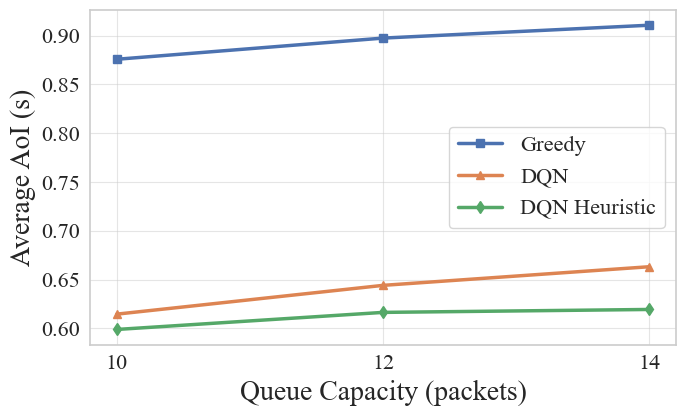

In [7]:
# Plot 1: Queue Analysis - AOI Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['queue_analysis']['x_values'], 
            data['queue_analysis']['aoi_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Queue Capacity (packets)')
ax.set_ylabel('Average AoI (s)')
# ax.set_title('Average AoI vs Queue Capacity')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.5)
ax.set_xticks(data['queue_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/queue_aoi.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('queue_aoi_mean.png', dpi=300, bbox_inches='tight')
plt.show()

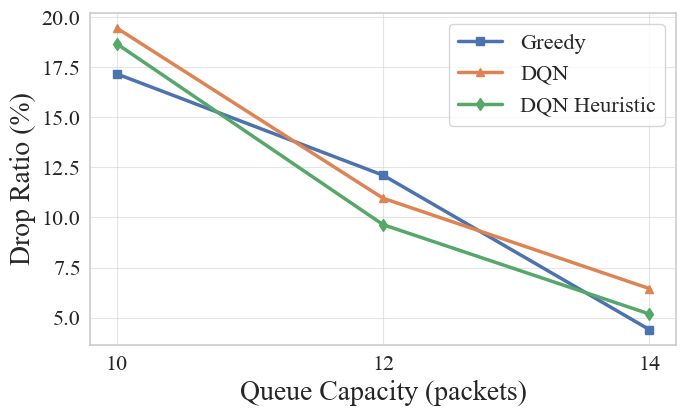

In [8]:
# Plot 2: Queue Analysis - Drop Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['queue_analysis']['x_values'], 
            data['queue_analysis']['drop_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Queue Capacity (packets)')
ax.set_ylabel('Drop Ratio (%)')
# ax.set_title('Drop Ratio vs Queue Capacity')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.5)
ax.set_xticks(data['queue_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/queue_drop_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/queue_drop_mean.png', dpi=300, bbox_inches='tight')
plt.show()

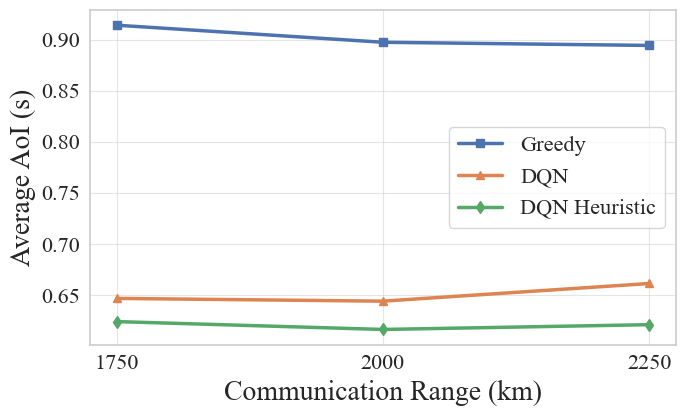

In [9]:
# Plot 3: Dmax Analysis - AOI Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['dmax_analysis']['x_values'], 
            data['dmax_analysis']['aoi_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Communication Range (km)')
ax.set_ylabel('Average AoI (s)')
# ax.set_title('Average AoI vs Communication Range')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.5)
ax.set_xticks(data['dmax_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/dmax_aoi_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/dmax_aoi_mean.png', dpi=300, bbox_inches='tight')
plt.show()

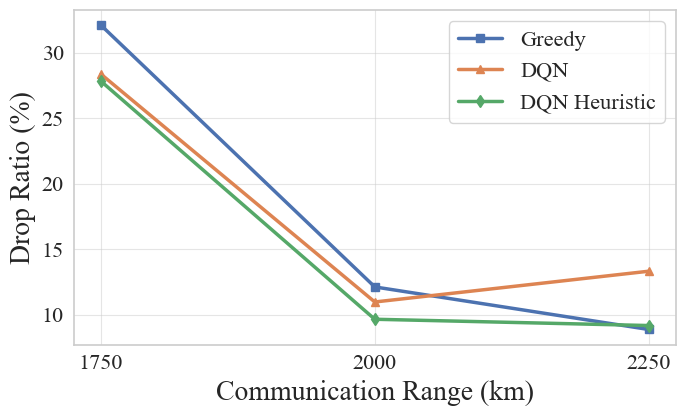

In [10]:
# Plot 4: Dmax Analysis - Drop Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['dmax_analysis']['x_values'], 
            data['dmax_analysis']['drop_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Communication Range (km)')
ax.set_ylabel('Drop Ratio (%)')
# ax.set_title('Drop Ratio vs Communication Range')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.5)
ax.set_xticks(data['dmax_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/dmax_drop_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/dmax_drop_mean.png', dpi=300, bbox_inches='tight')
plt.show()